# Recurrent Neural Networks

Natural language processing (NLP) is the practice of identify sequence patterns from language, to deduce the meaning behind the statement. In short, NLP has the goal of derviging information out of natural language (could be sequences text or speech). Another common term for NLP problems is sequence to sequence problems (seq2seq).

The purpose of this notebook is to download, prepare, and use a text dataset to build out multiple recurrent neural network (RNN) models to make predictions from the text. Additionally, I will create a model from an already pre-trained model on TensorFlow Hub.

The dataset I am going to use is Kaggle's introduction to NLP dataset (text samples of Tweets that predict as disaster or not disater).
* https://www.kaggle.com/competitions/nlp-getting-started

NOTE: Other sequence problems may include something like time series forecasting.

## Imports

In [1]:
import datetime
import io
import logging
import os
import pathlib
import random
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import performance_toolbox
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow as tf
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [2]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-09-21 13:38:35.975258


In [3]:
tf.__version__

'2.13.0'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [6]:
RANDOM_SEED = 42

## Helper Functions

In [7]:
def compare_results(results_1: ml_toolbox.analysis.classification.ClassificationPredictionMetrics,
                    results_2: ml_toolbox.analysis.classification.ClassificationPredictionMetrics) -> pd.Series:
    """ Compares results of two metrics and returns a boolean tensor on whether results_2 >= results_1.

        Args:
            results_1 (ClassificationPredictionMetrics): first results to compare against.
            results_2 (ClassificationPredictionMetrics): second results to compare against.

        Returns:
            (pd.Series) the boolean Series 
    """
    l1, l2 = dict(results_1), dict(results_2)
    l1.pop('name')
    l2.pop('name')
    df = pd.DataFrame([l1, l2]).T

    return df[1] >= df[0]

## Downloading, Analyzing, & Creating Datasets

The dataset for this notebook is looking at tweets, and determine whether or not the tweet is referring to a disaster or not.

* https://www.kaggle.com/competitions/nlp-getting-started

### Downloading & Analyzing Data

In [8]:
# Image dataset location
data_directory = pathlib.Path('./data/nlp_getting_started')
test_file = data_directory / 'test.csv'
train_file = data_directory / 'train.csv'

In [9]:
# Visualizing the text dataset
train_data = pd.read_csv(str(train_file))
test_data = pd.read_csv(str(test_file))

train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# Shuffling Data
train_data_shuffled = train_data.sample(frac=1, random_state=42)
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
# Viewing 10 random tweets and whether each one was a disaster or not
for i in range(10):
    row = train_data_shuffled.iloc[random.randint(0, len(train_data_shuffled))]
    print(f"Target: ({'Disaster' if row['target'] else 'Not Disaster'})")
    print(row['text'])
    print('\n', '-' * 40, '\n')

Target: (Not Disaster)
I like the weird ones like Rain of Mystical or Windstorm or Ocean Waves https://t.co/gCdxYdBSc4

 ---------------------------------------- 

Target: (Not Disaster)
IS ROSS DEAD NOOOOOOOOOOOO @MikeParrActor

 ---------------------------------------- 

Target: (Disaster)
CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR

 ---------------------------------------- 

Target: (Disaster)
I hear lightening and see thunder

 ---------------------------------------- 

Target: (Not Disaster)
Set some goals. Then demolish them ?? #fitness #inspiration

 ---------------------------------------- 

Target: (Not Disaster)
@IndiGo6E But if you are carful about spotting damage @the time of check in why not @the time of giving away baggage?! It's my loss all d wy

 ---------------------------------------- 

Target: (Disaster)
Find out how your fund was used for Typhoon Haiyan in the Philippines. See @DevPeace Haiyan Relief Funds Report http://t.c

In [12]:
# Lets look at the number of each target (disaster or not a disaster)
train_data_shuffled.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

### Preparing Data

To prep this data, there are a few things I need to do to get everything ready to build out my models.

1. Shuffle the training data set.
2. Split the training data set into a training and validation set (go to use 10% of the training data as the validation data).
3. Need to convert text into numbers.

In [13]:
# Constants
TEST_SIZE_PERCENTILE = 0.1

In [14]:
# Lets shuffle the training data
train_data_shuffled = train_data.sample(frac=1, random_state=42)
train_data_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


### Creating Datasets

#### Creating 100% Dataset

In [15]:
# Splitting the train data to split into training and validation datasets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_data_shuffled['text'].to_numpy(),
    train_data_shuffled['target'].to_numpy(),
    test_size=TEST_SIZE_PERCENTILE,
    random_state=RANDOM_SEED)

len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [16]:
# Verify the split worked as expected
train_sentences[:3], train_labels[:3]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....'],
       dtype=object),
 array([0, 0, 1]))

#### Creating 10% Dataset

In [17]:
# Creating 10% subset of the training data
train_10_percent_split = int(0.1 * len(train_sentences))

train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

##### Ensuring Representative Dataset

With the split, I need to make sure that the split is representative of the dataset as a whole. For instance, the 100% dataset has roughly a 4:3 ratio of tweets not disasters vs are disasters. 

In [18]:
# Verify split is representative of dataset
print('10% Value Counts')
print(pd.Series(np.array(train_labels_10_percent)).value_counts(), '\n')

print('100% Value Counts')
print(train_data_shuffled['target'].value_counts())

10% Value Counts
0    406
1    279
Name: count, dtype: int64 

100% Value Counts
target
0    4342
1    3271
Name: count, dtype: int64


## Experiments

To experiment and identify the best model, I am going to run the following experiments with the corresponding model to analyze the difference between the different types of models for modeling sequence based problems.

* Experiment-0 (Baseline): Naive Bayes with TF-IDF encoder (baseline model) NOTE: this is not a Deep Learning model
* Experiment-1: Feed-forward neural network (dense model)
* Experiment-2: LSTM (RNN)
* Experiment-3: GRU (RNN)
* Experiment-4: Bidirection-LSTM (RNN)
* Experiment-5: 1D Convolutional Neural Network
* Experiment-6: TensorFlow Hub Pretrained Feature Extractor
* Experiment-7: TensorFlow Hub Pretrained Feature Extractor (10% of Data)

### Experiment Constants

In [19]:
INPUT_SIZE = 1  # Input is entire sentence
OUTPUT_SIZE = 1

EPOCHS = 5

### Creating Common Layers

A handful of layers are used across multiple experiments. The following layers are required:

* `text_vectorizer` - Text Vectorization Layer
* `embedding` - Embedding Layer

#### Determine Constants

There are some certain parameters I need to identify and set as constants.

In [20]:
# Find average number of tokens
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [21]:
# Constants
MAX_VOCAB_LENGTH = 10000  # Max words to have in our vocab
MAX_SEQUENCE_LENGTH = 15  # Maximum length of a sequence (determined from code block aboce)

#### TextVectorization Layer

When dealing with a text problem, one of the first things to do before building a model is to convert text to numbers. There are a few ways to do this:

* Tokenization - direct mapping of token (a token could be a word or a character) to a number.
* Embedding - create a matrix of featyre vector for each token (the size of the feature vector can be defined and this embedding can be learned).

In [22]:
# Setting up a text vectorization layer (tokenization)
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=MAX_VOCAB_LENGTH,  # How many words in the vocabulary (None sets as no maximum number of tokens)
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)  # Padds (adds 0's to end of number) to make all the same length

In [23]:
# Adapt the vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [24]:
# Verify the text vectorizer was adapted correctly
sample_sentence = 'There\'s a flood in my street!'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [25]:
# Choose a random sentence from the train data and encode it
rand_i = random.randint(0, len(train_sentences))
print(f'Sentence: {train_sentences[rand_i]}')
print(f'Vectorized: {text_vectorizer([train_sentences[rand_i]])}')

Sentence: The summer program I worked for went the city pool we had to evacuate because one of my kids left a surprise. @jimmyfallon #WorstSummerJob
Vectorized: [[   2  270 1377    8 1733   10  492    2  182 1616   46   94    5  279
   152]]


In [26]:
# Getting the words in the vocab from the training data
words_in_vocab = text_vectorizer.get_vocabulary()
most_common_5_words = words_in_vocab[:5]
least_common_5_words = words_in_vocab[-5:]

len(words_in_vocab), most_common_5_words, least_common_5_words

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1'])

#### Embedding Layer

To make our embedding layer, I am going to use TensorFlow's `Embedding` layer. 

The parameters we care most about for our embedding layer are:

* `input dim` -  The size of the vocabulary
* `output dim` - The size of the output embedding vector, for example, a size of 100 mean each token would be represented by a vector of length 100.
* `input_length` - The length of the sequences being passed to the embedding layer.

In [27]:
# Constants
EMBEDDING_OUTPUT_DIM = 128  # GPU's work well when number is divisible by 8

In [28]:
embedding = tf.keras.layers.Embedding(input_dim=MAX_VOCAB_LENGTH,
                                     output_dim=EMBEDDING_OUTPUT_DIM,
                                     input_length=MAX_SEQUENCE_LENGTH)
embedding

In [29]:
# Verify the embedding layer worked
random_sentence = random.choice(train_sentences)
embedded_sentence = embedding(text_vectorizer([random_sentence]))
print('Sentence: \n', random_sentence)
print('Embedded Version: \n', embedded_sentence)

Sentence: 
 If you think going to demolish Drake's house over some ghostwriting shit you should know that Rihanna lives next door.
Embedded Version: 
 tf.Tensor(
[[[ 0.01692742  0.01280296 -0.03794461 ...  0.00523317  0.0294095
   -0.0110469 ]
  [-0.02869302 -0.04056253  0.00132649 ... -0.04541462  0.02573365
   -0.03644288]
  [ 0.03888735  0.03062843  0.02743541 ... -0.01527388 -0.0280211
   -0.00052346]
  ...
  [-0.02869302 -0.04056253  0.00132649 ... -0.04541462  0.02573365
   -0.03644288]
  [ 0.02156854  0.0073728  -0.02901694 ...  0.02057416  0.02068264
   -0.00769339]
  [-0.03211126  0.04029009 -0.03818759 ...  0.01901687 -0.04437354
   -0.02277442]]], shape=(1, 15, 128), dtype=float32)


### Experiment-0 (Baseline Model): Naive Bayes Model

As a baseline model, I am going to use SKLearn's Multinomial Naive Bayes algorithm using the TF-IDF formuila to convert words to numbers. This model will be used to compare the DL models against to judge performance.

NOTE: It's common practice to use non-LD algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [30]:
# Constnats
model_0_name = 'model_0_naive_bayes'

In [31]:
# Build Model
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

# Fit Model
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [32]:
# Evaluate model (SKlearn uses accuracy as the metric)
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score  # Accuracy

0.7926509186351706

In [33]:
# Make predictions
model_0_predictions = model_0.predict(val_sentences)

model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels,
                                                                                 model_0_predictions,
                                                                                 model_0_name)
model_0_results

ClassificationPredictionMetrics(accuracy=0.7926509186351706, precision=0.8111390004213173, recall=0.7926509186351706, f1=0.7862189758049549, name='model_0_naive_bayes')

### Experiment-1: Feed Forward Dense Model

The first test I am going to run against my baseline model is to use the traditional Dense DL model.

In [34]:
# Constants
model_1_name = 'model_1_feed_forward'

In [35]:
# Build model
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,), dtype=tf.string) # Inputs are 1 dimensional strings
x = text_vectorizer(inputs)  # Turn the input text into numbers
x = embedding(x)  # Embed the text
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)  # Create the output layer

model_1 = tf.keras.models.Model(inputs, outputs, name=model_1_name)
model_1.summary()

Model: "model_1_feed_forward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable para

In [36]:
# Compile Model
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [37]:
# Fit the model
model_1_history = model_1.fit(
    x=train_sentences,
    y=train_labels,
    epochs=EPOCHS,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_1_name)
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_1_feed_forward/tensorboard/20230921-133836
Epoch 1/5
215/215 [==============================] - 1s 4ms/step - loss: 0.6113 - accuracy: 0.6933 - val_loss: 0.5355 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4410 - accuracy: 0.8206 - val_loss: 0.4674 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3467 - accuracy: 0.8589 - val_loss: 0.4582 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2834 - accuracy: 0.8923 - val_loss: 0.4661 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2365 - accuracy: 0.9107 - val_loss: 0.4784 - val_accuracy: 0.7913


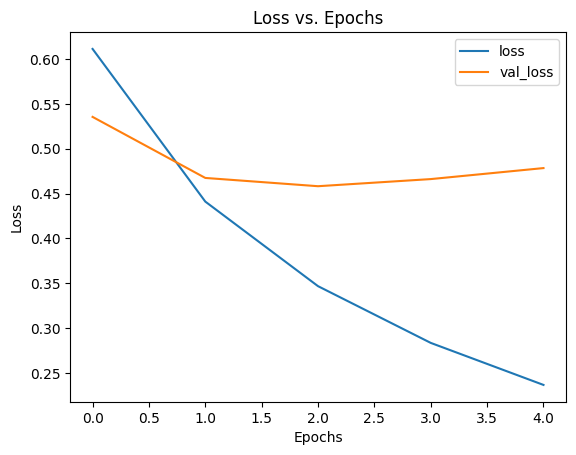

In [38]:
ml_toolbox.analysis.history.plot_history(model_1_history, 'loss')

In [39]:
# Get prediction probabilities
model_1_pred_probs = model_1.predict(val_sentences)

# Convert prediction probabilities to 1 or 0
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels, model_1_preds, model_1_name)
model_1_results

24/24 [==============================] - 0s 614us/step


ClassificationPredictionMetrics(accuracy=0.7913385826771654, precision=0.7962095559621156, recall=0.7913385826771654, f1=0.788475062664411, name='model_1_feed_forward')

In [40]:
# Analyze data against the baseline data
compare_results(model_0_results, model_1_results)

accuracy     False
precision    False
recall       False
f1            True
dtype: bool

#### Visualizing the Learned Embeddings

To visualize the embedding matrix, TensorFlow has a handy tool called projector that visualizes the matrix.

NOTE: To utilize the projector tool, you need to create a vectors.tsv and metadata.tsv that will be uploaded to the projector website linked below.

* https://www.tensorflow.org/text/guide/word_embeddings
* https://projector.tensorflow.org/

In [41]:
# Get the weight matrix of embedding layer
# These are the numerical representation of each token in our training data, learned for 5 epochs.
# Create embedding files (These will be uploaded to the embedding projector)
ml_toolbox.analysis.language.export_embedding_projector_data(
    model_name=model_1_name,
    embedded_layer_weights=model_1.get_layer('embedding').get_weights()[0],
    vocabulary=words_in_vocab,
    include_timestamp=True)

### Experiment-2: LSTM

LSTM (Long Short Term Memory) is one of the most popular RNN models.

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNN's/Dense) -> Output
```

In [42]:
# Constants
model_2_name = 'model_2_lstm'

In [43]:
# Create an LSTM Model
# Build model
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,), dtype=tf.string) # Inputs are 1 dimensional strings

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = embedding(x)  # Embed the text
# when you're stacking RNN cells together, you need to set return sequences to True
# x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [44]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [45]:
# Fit the Model
model_2_history = model_2.fit(
    train_sentences,
    train_labels,
    epochs=EPOCHS,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_2_name)
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_2_lstm/tensorboard/20230921-133841
Epoch 1/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2196 - accuracy: 0.9256 - val_loss: 0.5498 - val_accuracy: 0.7887
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1555 - accuracy: 0.9421 - val_loss: 0.6393 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1268 - accuracy: 0.9539 - val_loss: 0.6546 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1037 - accuracy: 0.9594 - val_loss: 0.7599 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0828 - accuracy: 0.9675 - val_loss: 1.0746 - val_accuracy: 0.7703


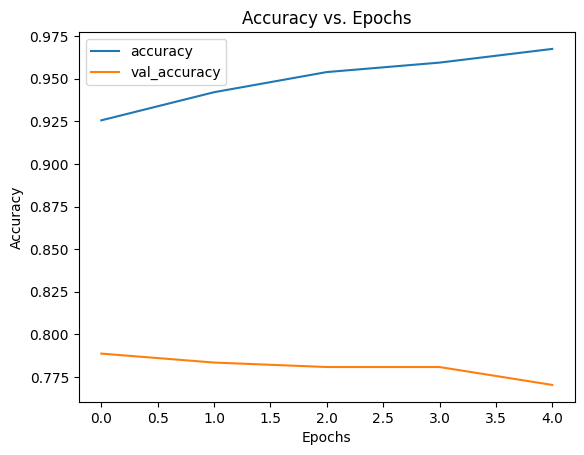

In [46]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'accuracy')

In [47]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels, model_2_preds, model_2_name)
model_2_results

24/24 [==============================] - 0s 2ms/step


ClassificationPredictionMetrics(accuracy=0.7703412073490814, precision=0.7701208199177533, recall=0.7703412073490814, f1=0.7695203715374298, name='model_2_lstm')

In [48]:
# Analyze data against the baseline data
compare_results(model_0_results, model_2_results)

accuracy     False
precision    False
recall       False
f1           False
dtype: bool

### Experiment-3: GRU

Another popular and effective RNN component is the FRU or gated recurrent unit. The GRU cell has similar features to an LSTM cell, but has less parameters.

In [49]:
# Constants
model_3_name = 'model_3_gru'

In [50]:
# Create the GRU model
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(64)(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)
model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [51]:
# Compile the Model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [52]:
# Fit Model
model_3_history = model_3.fit(
    train_sentences,
    train_labels,
    epochs=EPOCHS,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_3_name)
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_3_gru/tensorboard/20230921-133854
Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.1542 - accuracy: 0.9409 - val_loss: 0.6455 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0821 - accuracy: 0.9710 - val_loss: 0.8371 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0722 - accuracy: 0.9737 - val_loss: 0.9454 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0636 - accuracy: 0.9747 - val_loss: 1.1245 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0551 - accuracy: 0.9766 - val_loss: 1.2223 - val_accuracy: 0.7756


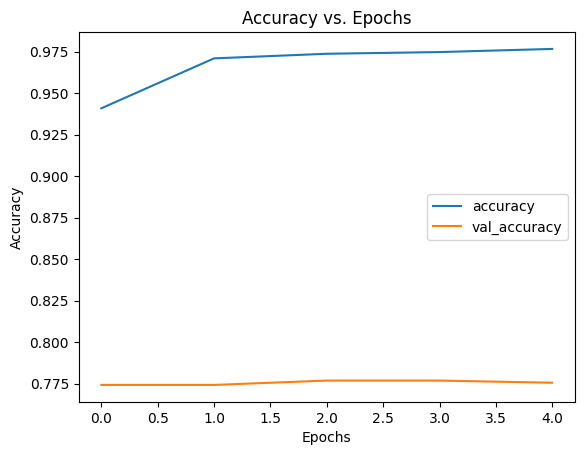

In [53]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'accuracy')

In [54]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

model_3_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels, model_3_preds, model_3_name)
model_3_results

24/24 [==============================] - 0s 1ms/step


ClassificationPredictionMetrics(accuracy=0.7755905511811023, precision=0.7783607884132258, recall=0.7755905511811023, f1=0.7730920642120304, name='model_3_gru')

In [55]:
compare_results(model_0_results, model_3_results)

accuracy     False
precision    False
recall       False
f1           False
dtype: bool

### Experiment-4: Bidirectional LSTM Model

Normal RNN's go from left to right, however, Bidirectional RNN's go from left to right as well as right to left. To summarize, it reads a sentence from left to right, then reads it from right to left.

NOTE: These are really only useful when going both directions can teach the network something useful when going both ways.

In [56]:
# Constants
model_4_name = 'model_4_bidirectional_lstm'

In [57]:
# Build out the Bidirectional Model
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_4_name)
model_4.summary()

Model: "model_4_bidirectional_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainabl

In [58]:
# compile model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [59]:
# Callback and Fit
model_4_history = model_4.fit(
    train_sentences,
    train_labels,
    epochs=EPOCHS,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_4_name),
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_4_bidirectional_lstm/tensorboard/20230921-133905
Epoch 1/5
215/215 [==============================] - 4s 12ms/step - loss: 0.1077 - accuracy: 0.9653 - val_loss: 0.9318 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0500 - accuracy: 0.9781 - val_loss: 1.3852 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0458 - accuracy: 0.9794 - val_loss: 1.3904 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0419 - accuracy: 0.9793 - val_loss: 1.6106 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0451 - accuracy: 0.9793 - val_loss: 1.3119 - val_accuracy: 0.7625


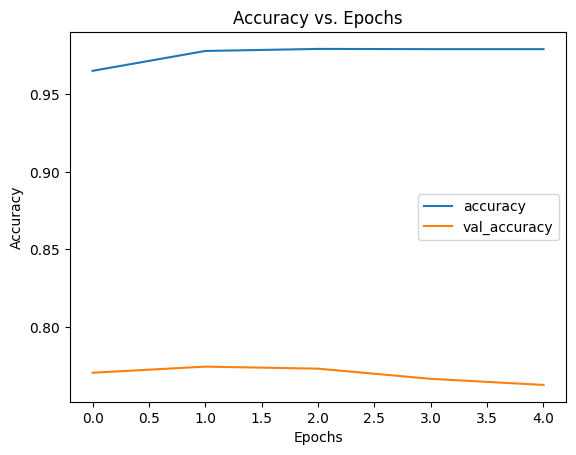

In [60]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'accuracy')

In [61]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

model_4_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels, model_4_preds, model_4_name)
model_4_results

24/24 [==============================] - 0s 2ms/step


ClassificationPredictionMetrics(accuracy=0.7624671916010499, precision=0.7642448462443391, recall=0.7624671916010499, f1=0.7601082692256481, name='model_4_bidirectional_lstm')

In [62]:
compare_results(model_0_results, model_4_results)

accuracy     False
precision    False
recall       False
f1           False
dtype: bool

### Experiment-5: 1D Convolutional Neural Network

We've used CNN's for images, but images are tpycally 2D, however, text data is 1D. 

The typical structure for Conv1D models:

```
Inputs -> Tokenization -> Embedding -> Layers (Conv1D + Pooling) -> Outputs
```

In [63]:
# Constants
model_5_name = 'model_5_1d_cnn'

In [64]:
# build the model
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', padding='valid')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_5 = tf.keras.models.Model(inputs, outputs, name=model_5_name)
model_5.summary()

Model: "model_5_1d_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)              

In [65]:
# Compile model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [66]:
# Callback and Fit
model_5_history = model_5.fit(
    train_sentences,
    train_labels,
    epochs=EPOCHS,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_5_name),
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_5_1d_cnn/tensorboard/20230921-133919
Epoch 1/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1316 - accuracy: 0.9628 - val_loss: 0.8695 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0761 - accuracy: 0.9720 - val_loss: 1.0235 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0618 - accuracy: 0.9755 - val_loss: 1.0984 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0536 - accuracy: 0.9774 - val_loss: 1.1899 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0502 - accuracy: 0.9775 - val_loss: 1.2161 - val_accuracy: 0.7598


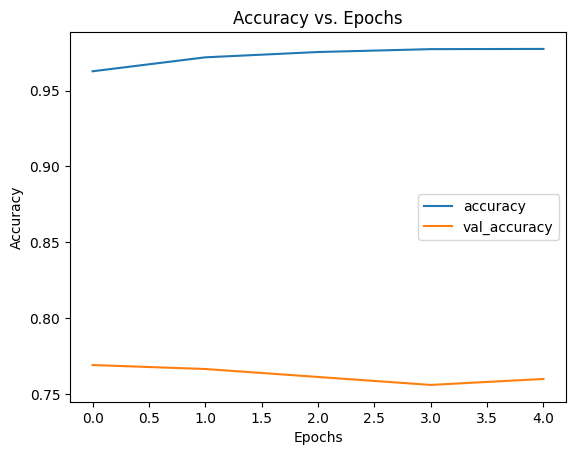

In [67]:
ml_toolbox.analysis.history.plot_history(model_5_history, 'accuracy')

In [68]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

model_5_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels, model_5_preds, model_5_name)
model_5_results

24/24 [==============================] - 0s 893us/step


ClassificationPredictionMetrics(accuracy=0.7598425196850394, precision=0.7604578907479682, recall=0.7598425196850394, f1=0.758116023760764, name='model_5_1d_cnn')

In [69]:
compare_results(model_0_results, model_5_results)

accuracy     False
precision    False
recall       False
f1           False
dtype: bool

### Experiment-6: TensorFlow Hub Pretrained Sentence Encoder

This model will use Transfer Learning with the `Universal Sentence Encoder` pretrained model on TensorFlow Hub (see link below).

* https://tfhub.dev/google/collections/universal-sentence-encoder/1

**NOTE** If when creating or testing the TensorFlow hub layer, an error might pop up saying certain files don't exist. If this occurs, delete the corresponding tensorflow hub directory listed in the error message and retry.

In [70]:
# Constants
model_6_name = 'model_6_use'
use_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'

#### Testing Universal Sentence Encoder Layer

In [71]:
# Testing out the transfer learning model
embed = hub.load(use_url)

embeddings = embed([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

INFO:absl:Using /var/folders/sj/rsg548nx63dc931tmwt4nnq80000gn/T/tfhub_modules to cache modules.
INFO:absl:Fingerprint not found. Saved model loading will continue.
tf.Tensor(
[[-0.03133015 -0.06338634 -0.016075   ... -0.03242781 -0.04575741
   0.05370457]
 [ 0.05080862 -0.01652432  0.0157378  ...  0.00976657  0.03170119
   0.01788119]], shape=(2, 512), dtype=float32)


#### Building Model

In [72]:
# Build Model
# Create a Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(use_url,
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

# Setup Layers
model_6 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid'),
], name=model_6_name)

model_6.summary()

INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [73]:
# Compile model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [74]:
# Callback and Fit
model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs=EPOCHS,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_6_name),
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_6_use/tensorboard/20230921-133930
Epoch 1/5
215/215 [==============================] - 2s 4ms/step - loss: 0.6476 - accuracy: 0.7341 - val_loss: 0.6112 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.5813 - accuracy: 0.7870 - val_loss: 0.5629 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.5388 - accuracy: 0.7945 - val_loss: 0.5316 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.5103 - accuracy: 0.7974 - val_loss: 0.5108 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4903 - accuracy: 0.8003 - val_loss: 0.4966 - val_accuracy: 0.7874


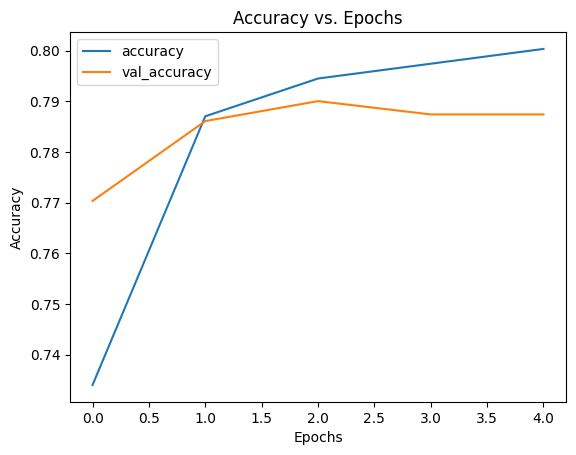

In [75]:
ml_toolbox.analysis.history.plot_history(model_6_history, 'accuracy')

In [76]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

model_6_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels, model_6_preds, model_6_name)
model_6_results

24/24 [==============================] - 0s 3ms/step


ClassificationPredictionMetrics(accuracy=0.7874015748031497, precision=0.7876057736843981, recall=0.7874015748031497, f1=0.7864229962328637, name='model_6_use')

In [77]:
compare_results(model_0_results, model_6_results)

accuracy     False
precision    False
recall       False
f1            True
dtype: bool

#### Findings:

Looks like this model beat the baseline the first time I ran this, but it was very close and isn't guranteed to beat it every time due to randomness.

### Experiment-7: TF Hub Pretrained USE but w/ 10% of Training Data

Transfer learning helps when you don't have a large dataset. To see how our model performs on a smaller dataset, I am going to replicate model 6, but I will only train it on 10% of the data.

In [78]:
# Constants
model_7_name = 'model_7_use_10p'

In [79]:
# Build Model
model_7 = tf.keras.models.clone_model(model_6)
model_7._name = model_7_name

model_7.summary()

INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "model_7_use_10p"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 256798337 (979.61 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [80]:
# Compile model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [81]:
# Callback and Fit
model_7_history = model_7.fit(
    train_sentences_10_percent,
    train_labels_10_percent,
    epochs=EPOCHS,
    validation_data=(val_sentences, val_labels),
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_7_name),
    ],
)

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_7_use_10p/tensorboard/20230921-133938
Epoch 1/5
22/22 [==============================] - 1s 15ms/step - loss: 0.6893 - accuracy: 0.5285 - val_loss: 0.6849 - val_accuracy: 0.6115
Epoch 2/5
22/22 [==============================] - 0s 6ms/step - loss: 0.6765 - accuracy: 0.6409 - val_loss: 0.6760 - val_accuracy: 0.6798
Epoch 3/5
22/22 [==============================] - 0s 6ms/step - loss: 0.6649 - accuracy: 0.7212 - val_loss: 0.6674 - val_accuracy: 0.7152
Epoch 4/5
22/22 [==============================] - 0s 6ms/step - loss: 0.6537 - accuracy: 0.7650 - val_loss: 0.6590 - val_accuracy: 0.7283
Epoch 5/5
22/22 [==============================] - 0s 7ms/step - loss: 0.6429 - accuracy: 0.7752 - val_loss: 0.6513 - val_accuracy: 0.7388


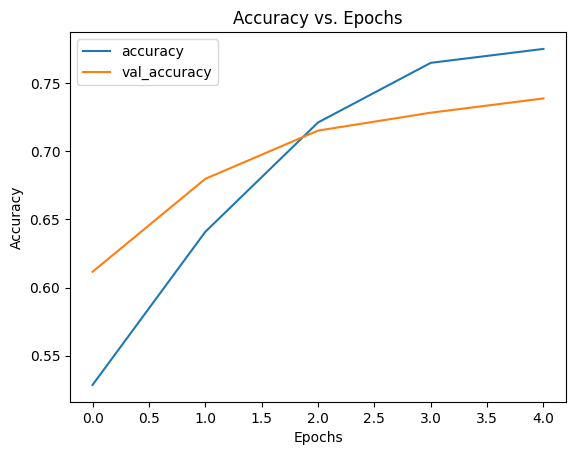

In [82]:
ml_toolbox.analysis.history.plot_history(model_7_history, 'accuracy')

In [83]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

model_7_results = ml_toolbox.analysis.classification.generate_prediction_metrics(val_labels, model_7_preds, model_7_name)
model_7_results

24/24 [==============================] - 0s 3ms/step


ClassificationPredictionMetrics(accuracy=0.7388451443569554, precision=0.7684082037138005, recall=0.7388451443569554, f1=0.7250290561544439, name='model_7_use_10p')

In [84]:
compare_results(model_0_results, model_7_results)

accuracy     False
precision    False
recall       False
f1           False
dtype: bool

#### Findings

Even with only 10% of the data, it performed only slightly worse than when training the model on 100% of the data.

## Analysis

Now that I have run through multiple experiments, I am going to compare the performance of each experiment.

In [85]:
all_models = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
    model_5_results,
    model_6_results,
    model_7_results,
]

all_model_results = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_models)
all_model_results

,accuracy,precision,recall,f1
model_0_naive_bayes,0.792651,0.811139,0.792651,0.786219
model_1_feed_forward,0.791339,0.796210,0.791339,0.788475
model_2_lstm,0.770341,0.770121,0.770341,0.769520
model_3_gru,0.775591,0.778361,0.775591,0.773092
model_4_bidirectional_lstm,0.762467,0.764245,0.762467,0.760108
model_5_1d_cnn,0.759843,0.760458,0.759843,0.758116
model_6_use,0.787402,0.787606,0.787402,0.786423
model_7_use_10p,0.738845,0.768408,0.738845,0.725029


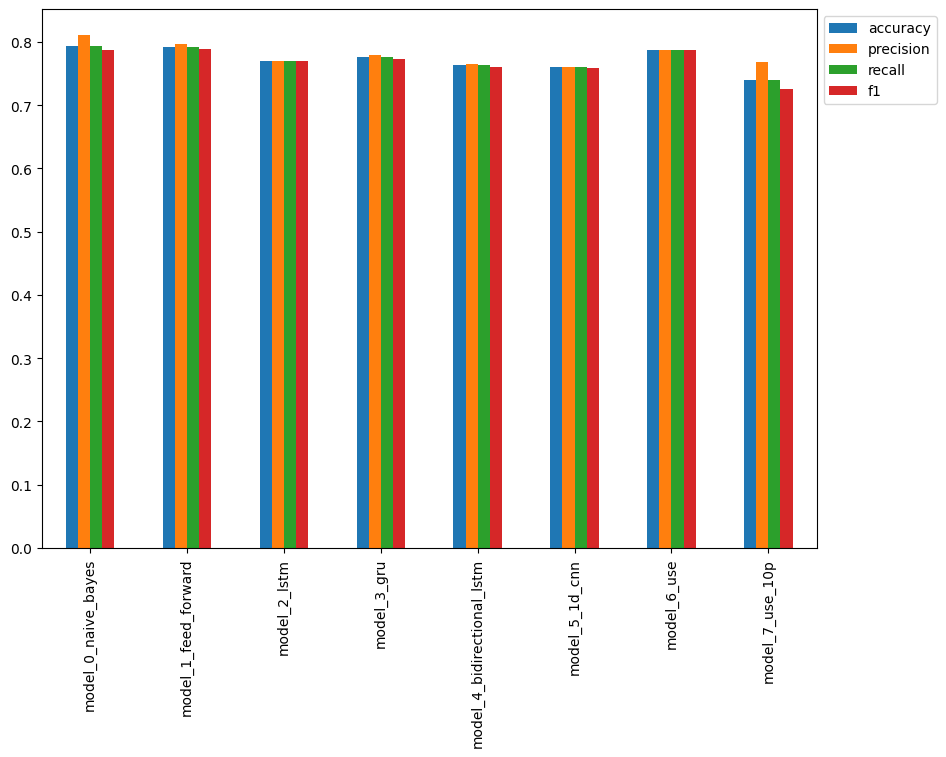

In [86]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

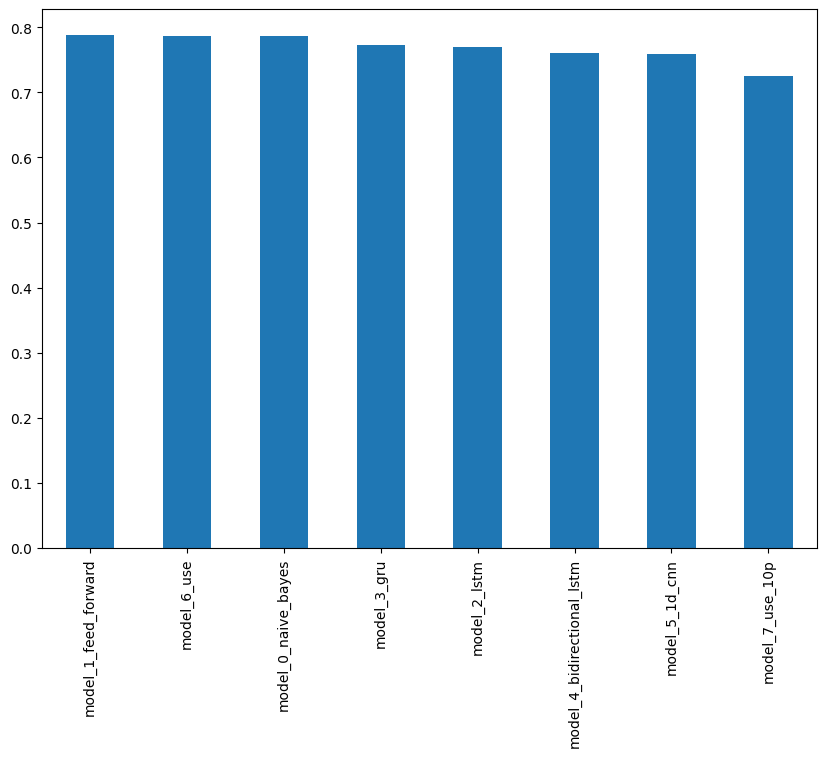

In [87]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

## Finding Most Wrong Examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples, which ones is it getting *most* wrong.

For example if a sample should have a label of 0, but our model predicts a prediction probability of 0.999, that is pretty wrong.

To do this, I am going to look at Model 6 because that model performed the best.

In [88]:
model_6_pred_probs[:10], model_6_preds[:10]

(array([[0.35629064],
        [0.67970073],
        [0.8457373 ],
        [0.32042992],
        [0.64254284],
        [0.72784024],
        [0.82995033],
        [0.835794  ],
        [0.7496509 ],
        [0.20943247]], dtype=float32),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>)

In [89]:
# CReateing DataFram with data
val_df = pd.DataFrame({
    'text': val_sentences,
    'target': val_labels,
    'pred': model_6_preds,
    'pred_prob': tf.squeeze(model_6_pred_probs)
})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.356291
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.679701
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.845737
3,@camilacabello97 Internally and externally scr...,1,0.0,0.320430
4,Radiation emergency #preparedness starts with ...,1,1.0,0.642543


In [90]:
# Find wrong predictions and sort by prediction probs
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.810396
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.757392
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.750449
181,Article by Michael Jackman at Metro Times Detr...,0,1.0,0.707782
759,FedEx will no longer transport bioterror patho...,0,1.0,0.700920
80,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,1.0,0.690110
630,Hollywood movie about trapped miners released ...,0,1.0,0.687844
695,A look at state actions a year after Ferguson'...,0,1.0,0.684901
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.679701
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.671953


In [91]:
most_wrong[-10:]

,text,target,pred,pred_prob
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.176523
382,I wanna set some shit on fire.,1,0.0,0.173631
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.170587
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.168815
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.168527
722,Indeed!! I am fully aware of that battle! I su...,1,0.0,0.167919
681,'The way you move is like a full on rainstorm ...,1,0.0,0.162055
352,@reriellechan HE WAS THE LICH KING'S FIRST CAS...,1,0.0,0.158945
233,I get to smoke my shit in peace,1,0.0,0.123209
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.118945


In [92]:
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f'Target: {target}, Pred: {pred}, Prob: {pred_prob}')
    print('Text: ', text)
    print('-' * 80)

Target: 1, Pred: 0.0, Prob: 0.1765231490135193
Text:  @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.17363113164901733
Text:  I wanna set some shit on fire.
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.17058710753917694
Text:  Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.16881507635116577
Text:  @DavidVonderhaar At least you were sincere ??
--------------------------------------------------------------------------------
Target: 1, Pred: 0.0, Prob: 0.16852742433547974
Text:  Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freesp

## Making Predictions on Test Dataset

In [93]:
test_sentences = test_data['text'].to_list()
test_samples = random.sample(test_sentences, 5)

for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample]))
    pred = tf.round(pred_prob)

    print(f'Pred: {int(pred)}, Prob: {pred_prob}')
    print('Text: ', test_sample)
    print('-' * 80, '\n')

1/1 [==============================] - 0s 15ms/step
Pred: 1, Prob: 0.6205379366874695
Text:  #LMÛªs @frauncestavern named one of the historic properties granted $$ by @NYGovCuomo to repair #Sandy damage http://t.co/OcAdC8vFyF
-------------------------------------------------------------------------------- 

1/1 [==============================] - 0s 14ms/step
Pred: 0, Prob: 0.2506726384162903
Text:  RT: A real burn book entry about CA: why the fuck is this place always BURNING
-------------------------------------------------------------------------------- 

1/1 [==============================] - 0s 14ms/step
Pred: 0, Prob: 0.4248542785644531
Text:  RT MME_AUSTIN: Why #Marijuana Is Critical For Research in Treating #PTSD

http://t.co/T6fuAhFp7p 
#hempoil #cannÛ_ http://t.co/RhE7dXM7Ey
-------------------------------------------------------------------------------- 

1/1 [==============================] - 0s 14ms/step
Pred: 0, Prob: 0.21992143988609314
Text:  To All The Meat-Loving Fem

## Speed vs. Score Tradeoff

In [94]:
model_6_performance = performance_toolbox.model.time_predictions(model_6, val_sentences, name=model_6_name)
model_6_performance

24/24 [==============================] - 0s 3ms/step


Performance(total_time=0.09662341699998933, total_predictions=762, name='model_6_use')

In [95]:
model_0_performance = performance_toolbox.model.time_predictions(model_0, val_sentences, name=model_0_name)
model_0_performance

Performance(total_time=0.00801537499999938, total_predictions=762, name='model_0_naive_bayes')

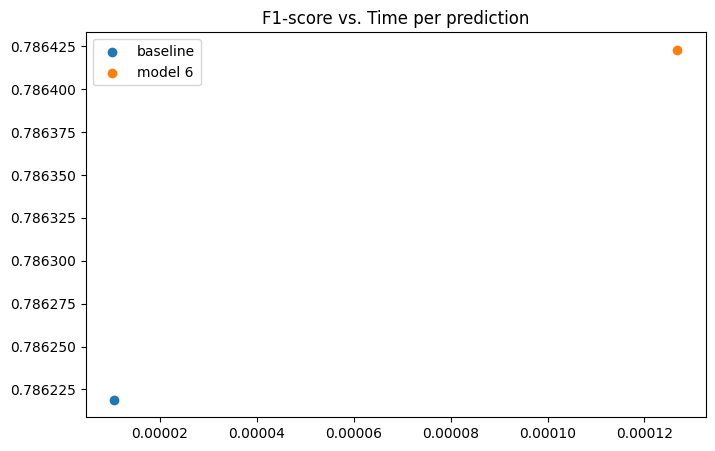

In [96]:
plt.figure(figsize=(8,5))
plt.scatter(model_0_performance.time_per_prediction, model_0_results.f1, label='baseline')
plt.scatter(model_6_performance.time_per_prediction, model_6_results.f1, label='model 6')
plt.legend()
plt.title('F1-score vs. Time per prediction');

#### Findings

When comparing out best model against our baseline model, the time difference is significant, even though the `F1` is virtually identical.